# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [103]:
import gzip
import pandas as pd
import numpy as np
import gc
import itertools
import plotly.express as px
import plotly.graph_objects as go
from time import strptime
import datetime

In [2]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

#### Reviews

In [3]:
#contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
#n = 2
for l in parse('steam_reviews.json.gz'):
    #if contador%n == 0:
    data_reviews.append(l)
    #else:
    #    pass
    #contador += 1

Recibimos las columnas necesarias para el preprocesamiento y analisis, ademas agiliza la conversion a DataFrame.

In [4]:
data_reviews = pd.DataFrame(data_reviews, columns=[
                            'username', 'hours', 'product_id', 'date', 'text'])

Conversion tipos de dato para columna "date":

In [5]:
data_reviews['date'] = pd.to_datetime(data_reviews['date'])

In [6]:
data_reviews.dtypes

username              object
hours                float64
product_id            object
date          datetime64[ns]
text                  object
dtype: object

In [7]:
print(data_reviews.shape)
data_reviews.head()

(7793069, 5)


,username,hours,product_id,date,text
0,Chaos Syren,0.1,725280,2017-12-17,This would not be acceptable as an entertainme...
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,328100,2017-12-27,looks like a facebook game
2,hello?<,14.6,328100,2017-10-16,Better than Minecraft
3,Cyderine916,5.0,35140,2018-01-04,I love and idolized Batman and this game is Ma...
4,DarklyThinking,16.6,35140,2018-01-04,Still worth playing in 2018.\nProbably my favo...


In [8]:
data_reviews.isna().sum()*100/len(data_reviews)

username      0.000000
hours         0.340521
product_id    0.000000
date          0.000000
text          0.000000
dtype: float64

#### Games

In [9]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [10]:
data_games.head(2)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN


## Analisis Exploratorio 

### Preprocesamiento Reviews

In [11]:
data_reviews.head()

,username,hours,product_id,date,text
0,Chaos Syren,0.1,725280,2017-12-17,This would not be acceptable as an entertainme...
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,328100,2017-12-27,looks like a facebook game
2,hello?<,14.6,328100,2017-10-16,Better than Minecraft
3,Cyderine916,5.0,35140,2018-01-04,I love and idolized Batman and this game is Ma...
4,DarklyThinking,16.6,35140,2018-01-04,Still worth playing in 2018.\nProbably my favo...


In [12]:
data_reviews.shape

(7793069, 5)

#### Reviews duplicados (Todos los campos)

Se analiza si existen registros duplicados en el dataset:

In [13]:
duplicated = data_reviews[data_reviews.duplicated()]
duplicated.shape

(831833, 5)

Se confirma la existencia registros duplicados, ahora se detalla un usuario aleatorio de estos registros:

In [14]:
duplicated.head()

,username,hours,product_id,date,text
2435,Foggy Dreamer,2.2,308040,2017-11-04,PROS:\n- Beautiful visuals and art\n- Decent p...
2632,little gamer64,20.5,271590,2018-01-04,I love this game
3264,Space_Wafer,7.4,427730,2017-12-31,So fun
3498,xanderwhovian,25.5,8880,2014-08-27,"freedom force is an absolutely amazing game, i..."
4028,feel it break,53.6,61700,2017-05-30,"Great and unique gameplay, lovely comic style ..."


Para probar, se selecciona el usuario **"feel it break"**

In [15]:
data_reviews[data_reviews.username == 'feel it break']

,username,hours,product_id,date,text
3880,feel it break,53.6,61700,2017-05-30,"Great and unique gameplay, lovely comic style ..."
4028,feel it break,53.6,61700,2017-05-30,"Great and unique gameplay, lovely comic style ..."
179401,feel it break,14.5,48700,2017-12-30,Well the first few hours into the game I had a...
3498769,feel it break,3.1,435480,2017-12-07,What a f***ing piece of turd of a game this is...
5340520,feel it break,323.5,97330,2017-10-12,Of all the Magic Games that came out and that ...
5518204,feel it break,469.0,316010,2016-12-11,Pro: You can build own magic decks\nCons: .......
6861873,feel it break,56.7,204450,2017-10-12,"Amazing game, very fast paced, stylish, combat..."


En los 2 primeros registros de esta busqueda se evidencia error de los datos, misma cantidad de horas, id de videojuego y fecha. Por lo tanto es razonable eliminar estos registros.

In [16]:
data_reviews.drop_duplicates(inplace=True, ignore_index=True)

In [17]:
data_reviews.shape

(6961236, 5)

In [18]:
data_reviews.isna().sum()

username          0
hours         25941
product_id        0
date              0
text              0
dtype: int64

#### Reviews duplicados (Username y product_id)

Habiendo eliminado registros duplicados, nos queda realizar un tratamiento especial a aquellos usuarios que han comentado un videojuego mas de una vez, como es un error de obtencion de datos, la accion a ejecutar consiste en dejar el ultimo review de un usuario a un videojuego mediante la fecha.

Usuarios con mas de un review a un videojuego:

In [19]:
repeated_reviews = data_reviews[data_reviews.duplicated(
    subset=['username', 'product_id'], keep=False)].sort_values(by='username')

In [20]:
print('Reviews del mismo usuario al mismo videojuego:', repeated_reviews.shape[0])

Reviews del mismo usuario al mismo videojuego: 121801


In [21]:
repeated_reviews.head()

,username,hours,product_id,date,text
4441474,!?,1.2,206210,2014-04-08,After all this time still can't play this beca...
4435144,!?,3.2,206210,2014-07-01,Hard to get trading cards
3526482,#1,11.2,440,2015-01-02,✰✰✰✰✰
3500502,#1,13.2,440,2015-09-15,"This game allows hours of fun, hundreds of dif..."
4719243,#GWForJulvärd2018,129.4,346110,2017-09-03,"grinding, grinding and more grinding. to get f..."


El usuario "!?" ha hecho dos comentarios al mismo videojuego (206210), el resultado entonces seria el ultimo comentario realizado.

**Adquiriendo ultimos reviews por fecha:**

In [22]:
# Para traer todas las columnas. Tarda mas!!
unrepeated_reviews = data_reviews.sort_values(
    by='date', ascending=False).drop_duplicates(subset=['username', 'product_id'])

# unrepeated_reviews = data_reviews.groupby(
#    ['username', 'product_id'], as_index=False).date.max()

Verificando:

In [23]:
unrepeated_reviews.query('username=="!?" & product_id=="206210"')

,username,hours,product_id,date,text
4435144,!?,3.2,206210,2014-07-01,Hard to get trading cards


In [24]:
data_reviews = unrepeated_reviews.copy()
del unrepeated_reviews

In [25]:
data_reviews.isna().sum()

username          0
hours         25741
product_id        0
date              0
text              0
dtype: int64

In [26]:
data_reviews.shape

(6889728, 5)

In [27]:
gc.collect()

96

### Preprocesamiento Games

In [28]:
data_games.head(3)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN


#### Valores faltantes

In [29]:
data_games.isna().sum()*100/len(data_games)

publisher         25.056792
genres            10.216275
app_name           0.006224
title              6.379337
url                0.000000
release_date       6.432239
tags               0.507235
discount_price    99.299829
reviews_url        0.006224
specs              2.084954
price              4.285047
early_access       0.000000
id                 0.006224
developer         10.266065
sentiment         22.349463
metascore         91.669519
dtype: float64

In [30]:
def heatmap_nan_values(data):
    plt.figure(figsize=(18, 10))
    nan_values = data.isna().sum()
    fig = sns.heatmap(data.isna(), cbar=False, yticklabels=False)
    col_width = fig.get_xlim()[1]/len(data.columns)
    for i, col in enumerate(data.columns):
        pos_text_x = col_width*(i+1/2)
        plt.text(pos_text_x, 0, nan_values[i], fontdict=dict(
            fontsize=15, rotation=33))
        plt.axvline(x=col_width*i, c='white', lw=2)

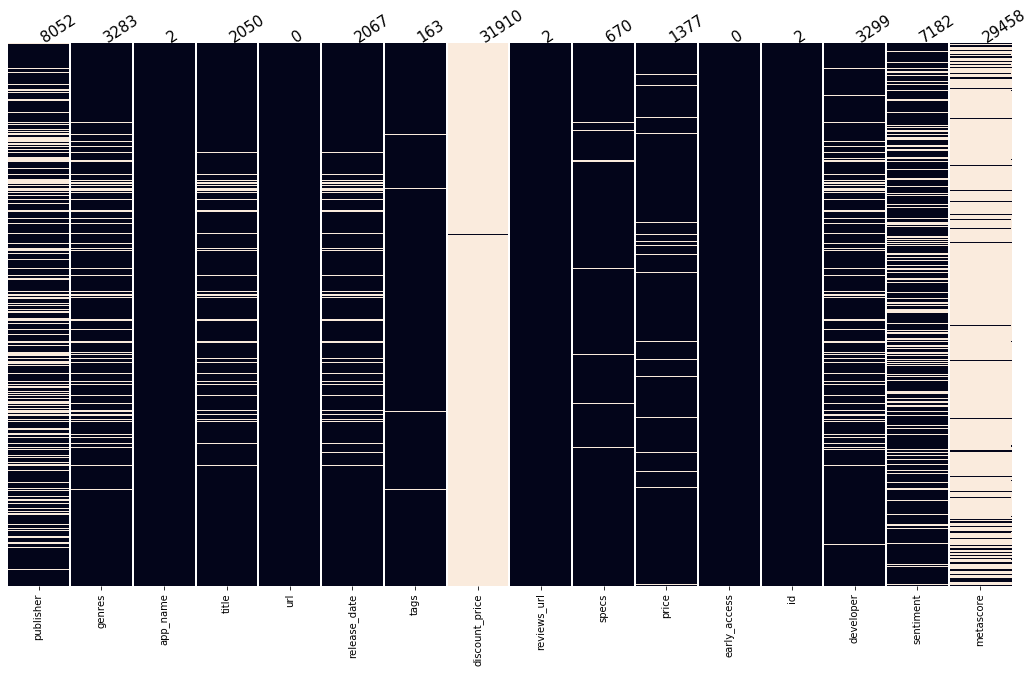

In [31]:
heatmap_nan_values(data_games)

In [32]:
data_games.shape

(32135, 16)

* Las columnas a continuacion no otorgan valor para el analisis exploratorio, se incluyen algunas con valores faltantes superiores al 90% del total de los datos.
* La columna **"sentiment"** se exluiria tambien ya que posee muchas categorias, algunas de ellas no son predecibles y no se podrian agrupar en categorias generales.
* El resto de columnas no incluidas aqui serviran para un posterior analisis exploratorio.

In [33]:
data_games.drop(columns=['title', 'discount_price', 'reviews_url',
                         'early_access', 'sentiment', 'metascore'], inplace=True)

In [34]:
data_games.isna().sum()

publisher       8052
genres          3283
app_name           2
url                0
release_date    2067
tags             163
specs            670
price           1377
id                 2
developer       3299
dtype: int64

##### Videjuegos con nombre faltante:

El nombre de la aplicacion es importante a la hora de conocer que aplicacion se va a recomendar.

In [35]:
data_games[data_games.app_name.isna()]

,publisher,genres,app_name,url,release_date,tags,specs,price,id,developer
74,NaN,NaN,NaN,http://store.steampowered.com/,NaN,NaN,NaN,19.99,NaN,NaN
2580,NaN,"[Action, Indie]",NaN,http://store.steampowered.com/app/317160/_/,2014-08-26,"[Action, Indie]","[Single-player, Game demo]",NaN,317160,NaN


* Al parecer hay un videojuego que no existe (indice 74), se puede verificar examinando su url la cual no esta compuesta por id ni nombre del videojuego.  
* Con el segundo registro obtenido, al acceder a su url (http://store.steampowered.com/app/317160/_/) parece ser una version Demo gratuita, no aparece el titulo, ni imagenes adjuntas pero tiene reviews de algunos usuarios, en la imagen portada de se logra apreciar su nombre ("Duet").  
Al consultar otro videojuego con este mismo nombre encontramos la version completa de pago con los datos completos.

In [36]:
data_games.query('app_name=="Duet"')

,publisher,genres,app_name,url,release_date,tags,specs,price,id,developer
4103,Kumobius,"[Action, Indie]",Duet,http://store.steampowered.com/app/292600/Duet/,2015-08-03,"[Indie, Action, Minimalist, Great Soundtrack, ...","[Single-player, Steam Achievements, Full contr...",4.99,292600,Kumobius


Asignando nombre de videojuego faltante:

In [37]:
data_games.iloc[2580].app_name = 'Duet'

Aplicando dropna() al dataset con valores faltantes por la columna **"app_name"**

In [38]:
data_games.dropna(subset=['app_name'], inplace=True)
data_games.isna().sum()

publisher       8051
genres          3282
app_name           0
url                0
release_date    2066
tags             162
specs            669
price           1377
id                 1
developer       3298
dtype: int64

##### Videojuegos con ID faltante

El ID del videojuego tambien es un identificador importante y no se debe ignorar.

In [39]:
data_games[data_games.id.isna()]

,publisher,genres,app_name,url,release_date,tags,specs,price,id,developer
30961,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...","[Single-player, Steam Achievements, Steam Trad...",19.99,NaN,"Rocksteady Studios,Feral Interactive (Mac)"


Vemos que la url contiene el id faltante y en este caso se obtuvo un solo registro, con un simple _"copy - paste"_ de este id y conociendo el indice se podria solucionar, pero en caso de haber obtenido multiples registros la tarea seria mas tediosa si se hace manualmente. Crear una iteracion sobre estos videojuegos para completar el id es lo mas viable en este caso:

Split basico a una url para obtener el id:

In [40]:
'http://store.steampowered.com/app/200260'.split('app/')[1].split('/')[0]

'200260'

Aplicando la estrategia en un loop:

In [41]:
games_id_nan = data_games[data_games.id.isna()].index
for idx in games_id_nan:
    url = data_games.loc[idx].url
    id_game = url.split('app/')[1].split('/')[0]
    data_games.loc[idx].id = id_game

In [42]:
data_games[data_games.index==30961]

,publisher,genres,app_name,url,release_date,tags,specs,price,id,developer
30961,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...","[Single-player, Steam Achievements, Steam Trad...",19.99,200260,"Rocksteady Studios,Feral Interactive (Mac)"


In [43]:
data_games.isna().sum()

publisher       8051
genres          3282
app_name           0
url                0
release_date    2066
tags             162
specs            669
price           1377
id                 0
developer       3298
dtype: int64

In [44]:
data_games.shape

(32134, 10)

#### Transformacion de precios

La columna "price" esta conforma por valores numericos y categoricos, entonces haremos un filtro para obtener y analizar estas categorias.

In [45]:
prices = np.array([i for i in list(data_games.price) if (type(i) == str)])
np.unique(prices)

array(['Free', 'Free Demo', 'Free HITMAN™ Holiday Pack', 'Free Mod',
       'Free Movie', 'Free To Play', 'Free to Play', 'Free to Try',
       'Free to Use', 'Install Now', 'Install Theme', 'Play Now',
       'Play WARMACHINE: Tactics Demo', 'Play for Free!', 'Play the Demo',
       'Starting at $449.00', 'Starting at $499.00', 'Third-party'],
      dtype='<U29')

**NOTA**: Se observa dos veces la categoria "Starting at $449.00", parece que el metodo np.unique() lo distinguio como categorias diferentes, algo inusual.  

Creando nuevas categorias para la columna precio, actualmente contamos con valores numericos y categoricos, la unica categoria que se transformara a videojuego pago es "Starting at $499.00", el resto quedara como "free".

In [46]:
data_games['category_price'] = data_games.price.apply(
    lambda p: 'paid' if (type(p) == float or p.startswith('Starting')) else 'free')
data_games.drop('price', axis=1, inplace=True)
data_games.head()

,publisher,genres,app_name,url,release_date,tags,specs,id,developer,category_price
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],761140,Kotoshiro,paid
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",643980,Secret Level SRL,free
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",670290,Poolians.com,free
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",[Single-player],767400,彼岸领域,paid
4,NaN,NaN,Log Challenge,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",773570,NaN,paid


#### Videojuegos duplicados

Estrategia para eliminar videojuegos duplicados empezando por aquellos cuyo ID sea el mismo.

In [47]:
data_games[data_games.duplicated(
    subset=['id'], keep=False)].sort_values(by='publisher')

,publisher,genres,app_name,url,release_date,tags,specs,id,developer,category_price
13894,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...","[Single-player, Steam Achievements, Full contr...",612880,Machine Games,paid
14573,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/Wolfe...,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...","[Single-player, Steam Achievements, Full contr...",612880,Machine Games,paid
1068,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260/Batma...,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...","[Single-player, Steam Achievements, Steam Trad...",200260,"Rocksteady Studios,Feral Interactive (Mac)",paid
30961,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...","[Single-player, Steam Achievements, Steam Trad...",200260,"Rocksteady Studios,Feral Interactive (Mac)",paid


In [48]:
data_games.drop_duplicates(subset=['id'], ignore_index=True, inplace=True)

In [49]:
data_games.shape

(32132, 10)

In [50]:
data_games.isna().sum()

publisher         8051
genres            3282
app_name             0
url                  0
release_date      2066
tags               162
specs              669
id                   0
developer         3298
category_price       0
dtype: int64

**Analizando valores duplicados por publicador y nombre:** Se han encontrado los siguientes registros duplicados por nombre y publicador, pero estos no podrian ser removidos del dataset, al investigar algunos de estos se descubrio que para cada par de videojuegos duplicado, uno es requisito para iniciar el otro, o corresponden a versiones diferentes dependiendo de la region.

In [51]:
data_games[data_games.duplicated(
    subset=['app_name', 'publisher'], keep=False)].sort_values(by='publisher').head()

,publisher,genres,app_name,url,release_date,tags,specs,id,developer,category_price
27669,Chilled Mouse,"[RPG, Strategy]",Warhammer Quest,http://store.steampowered.com/app/329270/Warha...,2015-01-07,"[Strategy, RPG]","[Single-player, Downloadable Content, Steam Ac...",329270,"Twistplay,Rodeo Games",paid
27670,Chilled Mouse,"[RPG, Strategy]",Warhammer Quest,http://store.steampowered.com/app/326670/Warha...,2015-01-07,"[RPG, Strategy, Games Workshop, Turn-Based, Bo...","[Single-player, Steam Achievements, Steam Trad...",326670,"Rodeo Games,Twistplay",paid
13154,Rock Path Collective,"[Casual, Indie, Simulation]",MORE SWEATER? OK!,http://store.steampowered.com/app/773080/MORE_...,2017-12-19,"[Indie, Casual, Simulation]","[Single-player, Downloadable Content, Steam Ac...",773080,Triple-Star Studio,paid
31994,Rock Path Collective,"[Action, Casual, Indie, RPG, Simulation]",MORE SWEATER? OK!,http://store.steampowered.com/app/746050/MORE_...,2017-12-29,"[Casual, Action, Indie, RPG, Simulation, Singl...","[Single-player, Steam Cloud, Stats, Steam Lead...",746050,Triple-Star Studio,paid
30176,SEGA,[Action],Aliens: Colonial Marines - Reconnaissance Pack,http://store.steampowered.com/app/224850/Alien...,2013-05-07,[Action],"[Single-player, Multi-player, Co-op, Downloada...",224850,Gearbox Software,paid


#### Parseo de Release Date

En esta seccion, se transformaran algunas fechas al formato correcto, la columna release_date ademas de contener fechas de tipo datetime y valores faltantes, tiene valores categoricos del cual es posible convertirlos a datetime gracias a que algunos de estos siguen el mismo patron o comportamiento.

In [52]:
data_games.release_date.value_counts()

2012-10-16    100
2017-08-31     92
2017-09-26     89
2017-06-21     82
2017-07-25     78
             ... 
2017 Q1         1
2012-04-01      1
2004-09-28      1
2015-10-17      1
2002-01-21      1
Name: release_date, Length: 3582, dtype: int64

La siguiente funcion servira para obtener aquellos valores que no corresponden a fechas validas para poder examinar los valores categoricos:

In [53]:
def isDateValid(x): 
    try:
        return datetime.datetime.strptime(x, '%Y-%m-%d')        
    except:
        return False

In [59]:
invalid_date_games = data_games[data_games.release_date.isna() == False]
invalid_date_games = [i for i in invalid_date_games.itertuples() if not isDateValid(i.release_date)]
invalid_date_games = pd.DataFrame(invalid_date_games)
invalid_date_games.release_date

0            Soon..
1              2017
2         Beta测试已开启
3          Jun 2009
4          Oct 2010
           ...     
280      15.01.2018
281        Q1, 2018
282     Coming Soon
283            2016
284    January 2018
Name: release_date, Length: 285, dtype: object

De las categorias mostradas, las que tienen el nombre del mes (Completo o abreviado) y año es posible convertirlas. El nombre de la temporada y el año corresponden al mismo caso. **Ejemplos: Nov 2020, November 2020, Winter 2020, Summer 2020...**

* Para empezar, la funcion a continuacion retorna el numero del mes basado en el nombre, gracias a una de las librerias incluidas en Python.

In [60]:
def get_month(month):
    if (len(month)>3):
        return strptime(month,'%B').tm_mon
    else:
        return strptime(month,'%b').tm_mon

In [61]:
print('Noviembre:', get_month('Nov'))
print('Noviembre:', get_month('November'))
print('Abril:', get_month('Apr'))
print('Abril:', get_month('April'))

Noviembre: 11
Noviembre: 11
Abril: 4
Abril: 4


Las temporadas se definiraran segun el pais, en este caso es Estados Unidos. El diccionario contiene el nombre de la temporada y el mes en que inicia:

In [62]:
SEASONS = {'Winter': 12, 'Summer': 7, 'Fall': 10, 'Spring': 4}

* Esta funcion obtiene una fecha como variable categorica y la transforma a datetime, si no corresponde al patron detectado la convierte a valor faltante. El resto de fechas no estan definidas por un comportamiento, por lo tanto no es posible transformarlas una por una y son mas de 100 categorias.

In [63]:
def get_date(date_sring):
    try:
        sep = date_sring.split()
        # Primero verifica si es una temporada
        if (sep[0] in SEASONS.keys()):
            return datetime.datetime(year=int(sep[1]), month=SEASONS.get(sep[0]), day=1).date()

        # Sino, utiliza la funcion anterior para obtener el numero del mes a partir del nombre.
        return datetime.datetime(year=int(sep[1]), month=get_month(sep[0]), day=1).date()
    except:
        # Retorna valor faltante si no se cumplen los dos casos, no es posible hacer mas magia!!
        return np.nan

Ejemplo:

In [64]:
example_date = 'Nov 2020'
print('Noviembre', get_date(example_date))

example_date = 'November 2020'
print('Noviembre', get_date(example_date))

example_date = 'Summer 2020'
print('Verano', get_date(example_date))

example_date = 'Winter 2020'
print('Winter', get_date(example_date))

Noviembre 2020-11-01
Noviembre 2020-11-01
Verano 2020-07-01
Winter 2020-12-01


* Transformando fechas categoricas:

In [65]:
invalid_date_games.release_date = invalid_date_games.release_date.apply(lambda x: f'{get_date(x)}')
invalid_date_games.release_date

0             nan
1             nan
2             nan
3      2009-06-01
4      2010-10-01
          ...    
280           nan
281           nan
282           nan
283           nan
284    2018-01-01
Name: release_date, Length: 285, dtype: object

* Aplicando cambios sobre el dataframe original

In [66]:
invalid_idx = invalid_date_games.Index.values
data_games.loc[invalid_idx,
               'release_date'] = invalid_date_games.release_date.values

* Verificando los cambios en los indices donde previamente existian estas categorias:

In [67]:
data_games.loc[invalid_idx].head()

,publisher,genres,app_name,url,release_date,tags,specs,id,developer,category_price
10,Qucheza,"[Action, Indie, Simulation, Early Access]",Uncanny Islands,http://store.steampowered.com/app/768570/Uncan...,nan,"[Early Access, Action, Indie, Simulation, Surv...",[Single-player],768570,Qucheza,paid
43,Breakout Studio,"[Indie, Massively Multiplayer, RPG, Early Access]",Life of Rome,http://store.steampowered.com/app/381620/Life_...,nan,"[Early Access, Massively Multiplayer, RPG, Ind...","[Multi-player, MMO, Steam Trading Cards, Parti...",381620,Breakout Studio,paid
44,zha7,"[Adventure, Free to Play, RPG, Early Access]",Idle Adventure,http://store.steampowered.com/app/714020/Idle_...,nan,"[Early Access, Free to Play, Adventure, RPG]","[MMO, Steam Achievements]",714020,"zha7,Phaedruns,Yingke Wu",paid
249,Erik Svedäng,"[Adventure, Indie]",Blueberry Garden,http://store.steampowered.com/app/29160/Bluebe...,2009-06-01,"[Adventure, Indie, Short, Puzzle]",[Single-player],29160,Erik Svedäng,paid
505,Paradox Interactive,"[RPG, Strategy]",Age of Wonders II: The Wizard's Throne,http://store.steampowered.com/app/61510/Age_of...,2010-10-01,"[Strategy, RPG, Turn-Based Strategy, Fantasy, ...","[Single-player, Multi-player]",61510,Triumph Studios,paid


Se ha completado el procedimiento de transformacion de fecha de lanzamiento, con esto es posible realizar un analisis exploratorio que conlleve Series de tiempo.

In [68]:
del invalid_date_games

In [69]:
data_games.isna().sum()

publisher         8051
genres            3282
app_name             0
url                  0
release_date      2066
tags               162
specs              669
id                   0
developer         3298
category_price       0
dtype: int64

In [71]:
gc.collect()

10511

### Exportando Datasets

In [72]:
data_reviews.to_csv('data_processed/data_reviews.csv', index=False)
data_games.to_csv('data_processed/data_games.csv', index=False)

### Consultas

**Lectura de Reviews procesado:**

Se obliga a que la columna username sea tipo string, porque existen usuarios cuyo nombre es "null" o "N/A", y Pandas los convierte a NaN. 
* Ejemplo de usuario "null": https://steamcommunity.com/profiles/76561198170981531/

In [2]:
new_data_reviews = pd.read_csv(
    'data_processed/data_reviews.csv', converters={'username': str})

**Lectura de videojuegos procesados:**

Al exportar a CSV se pierde el formato de algunos datos, los generos, tags y specs estaban compuestos de listas en la seccion de Preprocesamiento. En la lectura del archivo, aparecen como String, la siguiente funcion remueve las comillas simples y los corchetes en los extremos:

In [3]:
def toList(x):
    return x[1:-1].replace("'", '').split(', ') if (x is not np.nan) else nan

In [4]:
# Aqui se convierte cada elemento de tag en una lista
new_data_games = pd.read_csv('data_processed/data_games.csv', converters={
                             'genres': lambda x: toList(x),
                             'tags': lambda x: toList(x),
                             'specs': lambda x: toList(x)
                             })
new_data_games.release_date = pd.to_datetime(new_data_games.release_date)

Tipos de dato:

In [5]:
new_data_games.dtypes

publisher                 object
genres                    object
app_name                  object
url                       object
release_date      datetime64[ns]
tags                      object
specs                     object
id                         int64
developer                 object
category_price            object
dtype: object

In [6]:
new_data_games.head()

,publisher,genres,app_name,url,release_date,tags,specs,id,developer,category_price
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],761140,Kotoshiro,paid
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",643980,Secret Level SRL,free
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",670290,Poolians.com,free
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",[Single-player],767400,彼岸领域,paid
4,NaN,[],Log Challenge,http://store.steampowered.com/app/773570/Log_C...,NaT,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",773570,NaN,paid


In [7]:
new_data_reviews.head()

,username,hours,product_id,date,text
0,✪ switzerleλve,21.9,220,2018-01-05,The game is extremely immersive and had me on ...
1,RockLass,16.5,435030,2018-01-05,Quite enjoyable even for the long haul. Haven'...
2,Locke Kosta,2.9,232750,2018-01-05,"I gave this game a real shot, but the ♥♥♥♥♥♥ n..."
3,Feena,6.8,344440,2018-01-05,A classic hidden objects game with a good stor...
4,DanVanDam,13.6,404680,2018-01-05,I spent so far a good amount of time with this...


In [8]:
new_data_reviews.isna().sum()

username          0
hours         25741
product_id        0
date              0
text          16007
dtype: int64

Aqui tambien vemos como Pandas transformo a valor faltante aquellos reviews sin texto, algo poco relevante.

#### Usuarios únicos

In [9]:
print(f'{len(new_data_reviews.username.value_counts())} usuarios únicos')

2567538 usuarios únicos


#### Top 10 videojuegos mas populares

In [10]:
amount_by_productId = new_data_reviews.groupby('product_id').product_id.count().reset_index(name='amount')

Merge entre videojuegos y reviews:

In [11]:
reviews_games_amount = pd.merge(amount_by_productId, new_data_games, left_on='product_id',
                               right_on='id').sort_values(by='amount', ascending=False)
top10 = reviews_games_amount.head(10)

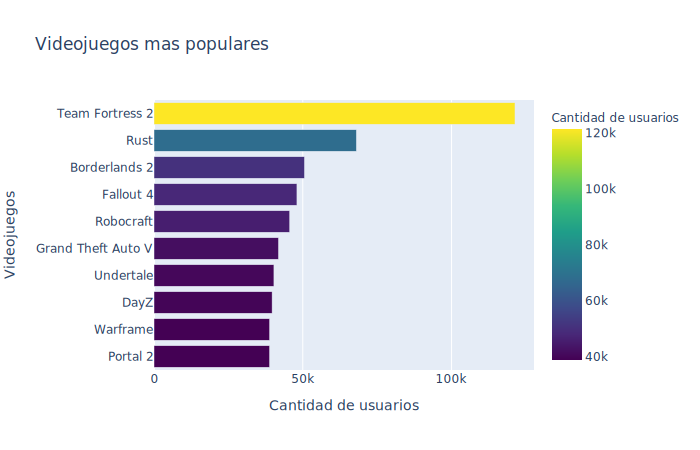

In [13]:
fig = px.bar(top10.sort_values(by='amount'), y='app_name', x='amount', color='amount', title='Videojuegos mas populares',
             color_continuous_scale='viridis', labels={'app_name': 'Videojuegos', "amount": 'Cantidad de usuarios'})
fig.show('svg')

#### Videojuegos con mas tiempo de juego

In [14]:
hours_by_productId = new_data_reviews.groupby(
    'product_id', as_index=False).hours.sum()
reviews_games_hours = pd.merge(hours_by_productId, new_data_games, left_on='product_id',
                               right_on='id').sort_values(by='hours', ascending=False)
hours10 = reviews_games_hours.head(10).sort_values(by='hours')

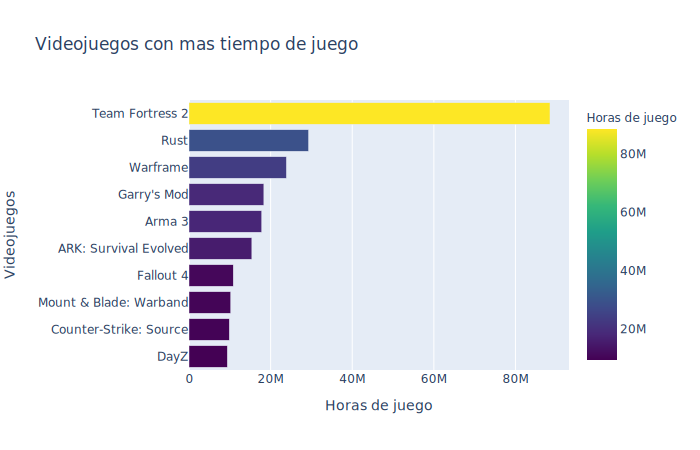

In [15]:
fig = px.bar(data_frame=hours10, y='app_name', x='hours', color='hours', title='Videojuegos con mas tiempo de juego',
       color_continuous_scale='viridis', labels={'app_name': 'Videojuegos', "hours": 'Horas de juego'})
fig.show('svg')

#### Genero mas popular

In [16]:
all_genres = list(itertools.chain(*new_data_games.genres))
value, count = np.unique(all_genres, return_counts=True)
order = np.argsort(count)

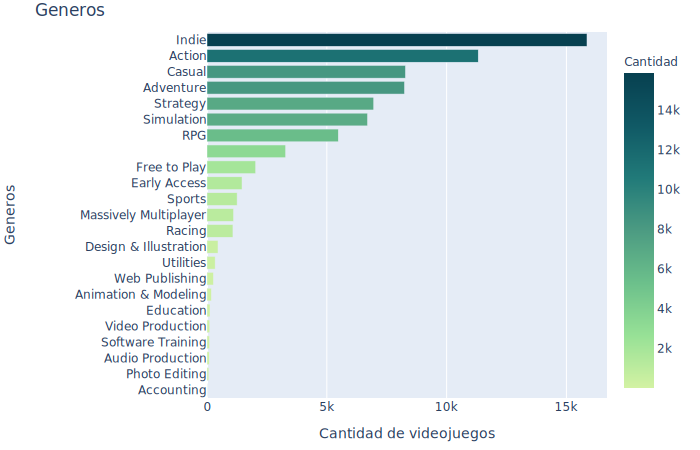

In [17]:
fig = px.bar(x=count[order], y=value[order], color=count[order], color_continuous_scale='emrld', title='Generos', labels={
    'x': 'Cantidad de videojuegos', 'y': 'Generos', 'color': 'Cantidad'})
fig.update_layout(
    autosize=False,
    width=500,
    height=1000,
    margin=dict(l=20, r=20, t=20, b=30)
)
fig.show('svg')

#### Videojuegos de pago mas jugados

In [18]:
df_items = new_data_games.query('category_price=="paid"')
merge_paid_games = pd.merge(amount_by_productId, df_items, left_on='product_id',
                            right_on='id').sort_values(by='amount', ascending=False).head(10)

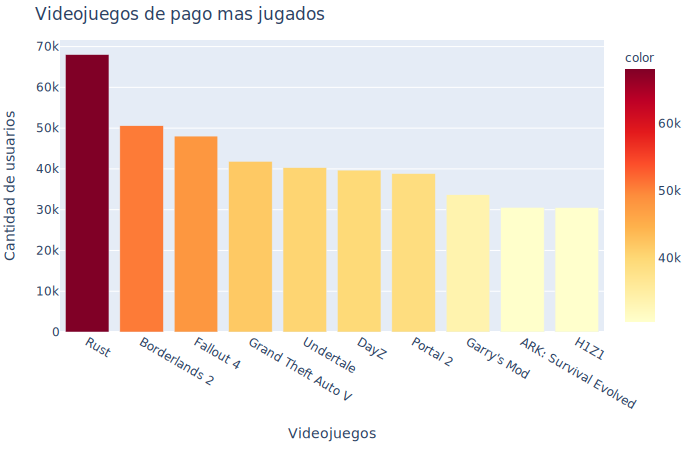

In [19]:
fig = px.bar(x=merge_paid_games.app_name, y=merge_paid_games.amount, title='Videojuegos de pago mas jugados',
             labels={'x': 'Videojuegos', 'y': 'Cantidad de usuarios'},
             color=merge_paid_games.amount, color_continuous_scale='ylorrd')
fig.update_layout(
    autosize=False,
    width=500,
    height=1000,
    margin=dict(l=30, r=20, t=40, b=30)
)
fig.show('svg')

#### Videojuegos gratis mas jugados

In [20]:
df_items = new_data_games.query('category_price=="free"')
merge_free_games = pd.merge(amount_by_productId, df_items, left_on='product_id',
                            right_on='id').sort_values(by='amount', ascending=False).head(10)

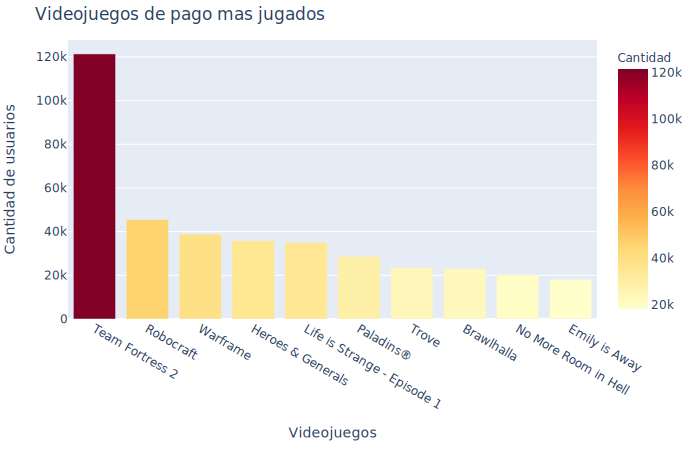

In [21]:
fig=px.bar(x=merge_free_games.app_name, y=merge_free_games.amount, title='Videojuegos de pago mas jugados',
             labels={'x': 'Videojuegos',
                     'y': 'Cantidad de usuarios', 'color': 'Cantidad'},
             color=merge_free_games.amount, color_continuous_scale='ylorrd')
fig.update_layout(
    autosize=False,
    width=500,
    height=1000,
    margin=dict(l=20, r=20, t=40, b=30)
)
fig.show('svg')

#### Cantidad de usuarios por precio de videojuego

In [22]:
sum_amount_categories = (reviews_games_amount.groupby('category_price').amount.sum() /
                         reviews_games_amount.amount.sum()).to_frame(name='amount').reset_index()

sum_amount_categories.sort_values(by='amount', ascending=False, inplace=True)
sum_amount_categories

,category_price,amount
1,paid,0.811985
0,free,0.188015


In [23]:
px.bar(sum_amount_categories, x='category_price',
             y='amount', title='% Usuarios por precio', color=['Pago', 'Gratis'],  width=500, height=400,
             labels={'category_price': 'Precios', 'amount': '% Usuarios', 'color': 'Categoria'})
#fig.show('svg')

#### Series de tiempo

In [110]:
games = new_data_games[new_data_games.release_date.isna() == False]
games = games.assign(month_name=games.release_date.dt.month_name())

games = games.month_name.value_counts()

games = pd.DataFrame({'month': games.index, 'amount': games.values})

games['n_month'] = pd.to_datetime(
    games.month, format='%B', errors='coerce').dt.month

games.sort_values(by='n_month', inplace=True)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=games.month,
    y=games.amount,
))
fig.update_layout(
    title='Videojuegos / Fechas de lanzamiento',
    autosize=False,
    width=2000,
    height=1000,
    xaxis=dict(title_text='Meses', titlefont=dict(size=18)),
    yaxis=dict(title_text="Videojuegos publicados", titlefont=dict(size=18))
)
fig.show('svg')

#### Algo con NPL

**Liberando memoria**

In [255]:
gc.collect()

16300

## Sistema de recomendacion

### Generando calificaciones

### Filtro colaborativo